In [451]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression as lr
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn import metrics
import plotly.express as px
from sklearn.model_selection import train_test_split, KFold, RepeatedStratifiedKFold, GridSearchCV
import plotly.graph_objects as go

In [452]:
df = pd.read_excel("./app_build/MDSInc_sales.xlsx")
df.head(3)

,order_id,order_date,ship_date,ship_mode,customer_name,segment,state,country,market,region,product_id,category,sub_category,product_name,sales,quantity,discount,profit,shipping_cost,order_priority
0,AG-2011-2040,2011-01-01 00:00:00,2011-06-01 00:00:00,Standard Class,Toby Braunhardt,Consumer,Constantine,Algeria,Africa,Africa,OFF-TEN-10000025,Office Supplies,Storage,"Tenex Lockers, Blue",408,2,0.0,106.140,35.46,Medium
1,IN-2011-47883,2011-01-01 00:00:00,2011-08-01 00:00:00,Standard Class,Joseph Holt,Consumer,New South Wales,Australia,APAC,Oceania,OFF-SU-10000618,Office Supplies,Supplies,"Acme Trimmer, High Speed",120,3,0.1,36.036,9.72,Medium
2,HU-2011-1220,2011-01-01 00:00:00,2011-05-01 00:00:00,Second Class,Annie Thurman,Consumer,Budapest,Hungary,EMEA,EMEA,OFF-TEN-10001585,Office Supplies,Storage,"Tenex Box, Single Width",66,4,0.0,29.640,8.17,High


In [453]:
cleaned_df = df.groupby("customer_name").sum().reset_index()
cleaned_df.head()

,customer_name,sales,quantity,discount,profit,shipping_cost
0,Aaron Bergman,18025,220,6.820,3102.58380,2570.39
1,Aaron Hawkins,17352,198,8.412,1452.88504,1832.44
2,Aaron Smayling,5657,106,1.520,619.16020,559.95
3,Adam Bellavance,13691,153,4.690,3616.55450,1386.70
4,Adam Hart,13176,180,4.932,473.36682,1142.53


In [454]:
new_df = cleaned_df.drop("customer_name", axis=1).to_numpy()
new_df[:5]

array([[1.80250000e+04, 2.20000000e+02, 6.82000000e+00, 3.10258380e+03,
        2.57039000e+03],
       [1.73520000e+04, 1.98000000e+02, 8.41200000e+00, 1.45288504e+03,
        1.83244000e+03],
       [5.65700000e+03, 1.06000000e+02, 1.52000000e+00, 6.19160200e+02,
        5.59950000e+02],
       [1.36910000e+04, 1.53000000e+02, 4.69000000e+00, 3.61655450e+03,
        1.38670000e+03],
       [1.31760000e+04, 1.80000000e+02, 4.93200000e+00, 4.73366820e+02,
        1.14253000e+03]])

In [455]:
sum_distances = []
K = range(1,15)
for k in K:
  k_mean = KMeans(n_clusters=k)
  k_mean.fit(new_df)
  sum_distances.append(k_mean.inertia_)

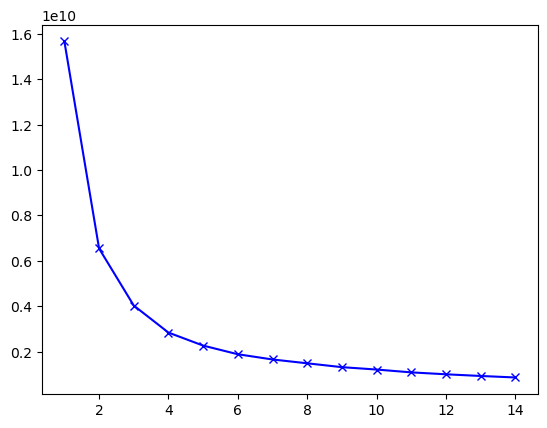

In [456]:
plt.plot(K, sum_distances, 'bx-')

In [476]:
k_mean_2 = KMeans(n_clusters=2)
model = k_mean_2.fit(new_df)
result = k_mean_2.labels_

print('Silhouette score', metrics.silhouette_score(new_df, result, metric='euclidean'))

Silhouette score 0.5393925270060999


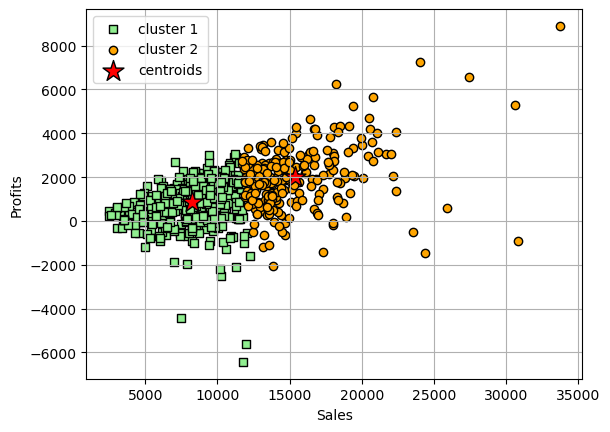

In [459]:
obj = {
    "sales": 0,
    "quantity": 1,
    "discount": 2,
    "profit": 3,
    "shipping_cost": 4,
}
column = obj["profit"]

plt.scatter(
    new_df[result == 0, 0], new_df[result == 0, column],
    c='lightgreen',
    marker='s', edgecolor='black',
    label='cluster 1'
)
plt.scatter(
    new_df[result == 1, 0], new_df[result == 1, column],
    c='orange',
    marker='o', edgecolor='black',
    label='cluster 2'
)
plt.scatter(
    model.cluster_centers_[:, 0], model.cluster_centers_[:, column],
    s=250, marker='*',
    c='red', edgecolor='black',
    label='centroids'
)

plt.legend(scatterpoints=1)
plt.xlabel("Sales")
plt.ylabel("Profits")
plt.grid()

---

In [460]:
linear_df = df.groupby("order_date").sum().reset_index()
linear_df = linear_df.drop("order_date", axis=1)
linear_df.head(3)

,sales,quantity,discount,profit,shipping_cost
0,808,19,0.80,198.8730,64.67
1,2457,54,1.35,603.4736,342.17
2,12567,177,5.94,1905.1539,1328.16


In [461]:
y = linear_df.iloc[:, 0]
X = linear_df.iloc[:, 1:]
X.shape, y.shape

((1069, 4), (1069,))

In [462]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((855, 4), (855,), (214, 4), (214,))

In [463]:
cv = RepeatedStratifiedKFold(n_splits=2, n_repeats=10)
linear_grid = {'positive': [True,False], 
                'fit_intercept': [True, False], 
                'n_jobs': [1, -1]}
linear = GridSearchCV( lr(), param_grid=linear_grid,
                          cv=cv, 
                          scoring='completeness_score', 
                          verbose=0)
linear.fit(X_train, y_train)

/opt/homebrew/Caskroom/miniconda/base/envs/min_ds-env/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=2.

/opt/homebrew/Caskroom/miniconda/base/envs/min_ds-env/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=2.

/opt/homebrew/Caskroom/miniconda/base/envs/min_ds-env/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=2.

/opt/homebrew/Caskroom/miniconda/base/envs/min_ds-env/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=2.

/opt/homebrew/Caskroom/miniconda/base/envs/min_ds-env/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWar

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=10, n_splits=2, random_state=None),
             estimator=LinearRegression(),
             param_grid={'fit_intercept': [True, False], 'n_jobs': [1, -1],
                         'positive': [True, False]},
             scoring='completeness_score')

In [464]:
model2 = lr(**linear.best_params_).fit(X_train, y_train)
pred = model2.predict(X_test)
result2 = pd.DataFrame(pred, columns=['sales'], index=X_test.index)
print('MSE of biased model:', metrics.mean_squared_error(y_test, pred))
print('MAE of biased model:', metrics.mean_absolute_error(y_test, pred))
print('Model score:', model2.score(X_test, y_test))

MSE of biased model: 5373883.030949747
MAE of biased model: 1270.4962113865342
Model score: 0.832616299600448


In [465]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=y_test.index, y=y_test.values, mode='markers', name='test', marker=dict(color='green')))
fig.add_trace(go.Scatter(x=result2['sales'].index, y=result2['sales'].values, mode='markers', name='predict', marker=dict(color='red')))
fig.update_layout(
    title='Scatter Plot',
    xaxis_title='X',
    yaxis_title='Y',
    showlegend=True,
    legend=dict(
        x=0,
        y=1,
        traceorder='normal',
        font=dict(family='sans-serif', size=12, color='black')
    )
)

In [466]:
df_2 = pd.read_csv("./app_build/Q12_2014.csv")
df_2 = df_2.groupby("order_date").sum().reset_index()
test_df = df_2.drop("order_date", axis=1)
test_df.head(3)

,sales,quantity,discount,profit,shipping_cost
0,3613,77,2.100,163.39000,390.07
1,867,23,1.600,68.06600,62.85
2,2914,43,1.002,91.09688,214.62


In [467]:
test_X = test_df.iloc[:, 1:]
y_true = test_df.iloc[:, 0]

In [468]:
y_test = model2.predict(test_X)
temp = y_true.to_numpy().reshape(-1, 1)

In [469]:
df_2["order_date"] = pd.to_datetime(df_2["order_date"]).dt.strftime("%d-%b-%Y")

In [470]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(df_2["order_date"].values), y=y_test, mode='lines', name='test', line=dict(color='green')))
fig.add_trace(go.Scatter(x=list(df_2["order_date"].values), y=temp[:, 0], mode='lines', name='predict', line=dict(color='red')))
fig.update_layout(
    title='Line Chart',
    xaxis_title='X',
    yaxis_title='Y',
    showlegend=True
)

In [471]:
metrics.r2_score(y_true.to_numpy(), y_test)

0.9276783652618676

---

In [472]:
def model_rmse(y_test, y_pred):
    return np.sqrt(np.mean((y_test.ravel() - y_pred.ravel())**2))

def train_each_feature_cross_validation(train, fold = 5):
    feature = {k: 0 for k in train.columns if k != 'sales'}

    for train_split, test_split in KFold(n_splits=fold, shuffle=True).split(train):
        for column in feature.keys():
            feature_train = np.array(train.iloc[train_split].loc[:,[column]])
            label_train = np.array(train.iloc[train_split].loc[:,['sales']])

            feature_test = np.array(train.iloc[test_split].loc[:,[column]])
            label_test = np.array(train.iloc[test_split].loc[:,['sales']])
                
            model = lr().fit(feature_train, label_train)
            pred = model.predict(feature_test)
            rmse = model_rmse(label_test, pred)

            feature[column] += rmse

    return {k: v/fold for k, v in feature.items()}

In [473]:
features = train_each_feature_cross_validation(pd.concat([X_train, y_train], axis=1))
best_feature = min(features, key=features.get)
print('The best feature in the dataset (most correlated feature to label):', best_feature)

The best feature in the dataset (most correlated feature to label): shipping_cost


In [477]:
fig = px.scatter(linear_df, x=linear_df[best_feature], y=linear_df['sales'], color=linear_df[best_feature])
fig.update_layout(xaxis_type='log', yaxis_type='log')

In [474]:
correlation_matrix = linear_df.corr(method='spearman')
fig = px.imshow(correlation_matrix, text_auto = True, color_continuous_scale = 'RdYlBu')
fig.show()